# Parte 3 do PP1 de RNA2020.1

## Tipos de Tarefas
Recapitulem que dados fornecem experiência sobre um problema. No caso em questão, sugira:
- [x] Uma tarefa de classificação mediante Aprendizado Supervisionado que poderia ser feita com
esta base de dados. Qual seria o atributo-alvo? Quais métricas de desempenho poderiam ser
aplicadas? Que tipo de validação seria apropriado?
- [x] Uma tarefa de regressão mediante Aprendizado Supervisionado que poderia ser feita com
esta base de dados. Qual seria o atributo-alvo? Quais atributos preditores a equipe considera
relevantes para o cenário?
- [x] Bônus: Qual tarefa de Aprendizado Não-Supervisionado poderia ser concebida neste contexto?

In [4]:
import warnings
warnings.filterwarnings('ignore')

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.pyplot import plot_date
%matplotlib inline
plt.style.use('ggplot')

In [5]:
file = 'dataset_limpo_covid19_manaus.csv'
df_dataset = pd.read_csv(file)
df_dataset.dt_notificacao = pd.to_datetime(df_dataset.dt_notificacao)
df_dataset

,idade,sexo,bairro,conclusao,dt_notificacao,tipo_teste
0,25,F,ADRIANOPOLIS,Recuperado,2020-03-20,RT-PCR
1,41,F,BETANIA,Recuperado,2020-03-27,RT-PCR
2,37,M,CIDADE NOVA,Recuperado,2020-04-27,TESTE RÁPIDO - ANTICORPO
3,44,M,SAO JORGE,Recuperado,2020-04-27,TESTE RÁPIDO - ANTICORPO
4,27,F,COLONIA TERRA NOVA,Recuperado,2020-04-24,TESTE RÁPIDO - ANTICORPO
...,...,...,...,...,...,...
6355,14,F,DA PAZ,Recuperado,2020-06-25,TESTE RÁPIDO - ANTÍGENO
6356,5,F,REDENCAO,Recuperado,2020-06-18,TESTE RÁPIDO - ANTÍGENO
6357,70,F,DOM PEDRO I,Recuperado,2020-02-06,TESTE RÁPIDO - ANTÍGENO
6358,68,M,JORGE TEIXEIRA,Recuperado,2020-01-06,RT-PCR


## Visualizando alguns valores dos atributos

In [6]:
df_dataset.sexo.value_counts()

F    3605
M    2755
Name: sexo, dtype: int64

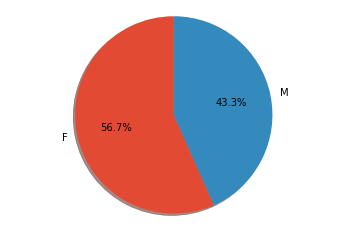

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'F', 'M'
sizes = df_dataset.sexo.value_counts()
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [8]:
df_dataset.conclusao.value_counts()

Recuperado    6347
Óbito           13
Name: conclusao, dtype: int64

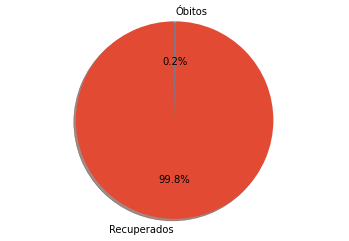

In [9]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Recuperados', 'Óbitos'
sizes = df_dataset.conclusao.value_counts()
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
df_dataset.idade.value_counts()

38    216
39    214
40    214
46    212
41    204
     ... 
96      1
97      1
90      1
94      1
93      1
Name: idade, Length: 97, dtype: int64

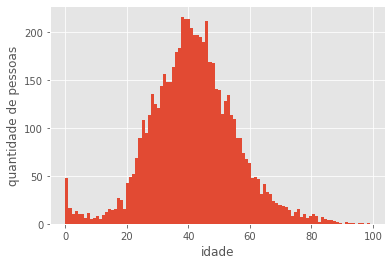

In [11]:
x = df_dataset.idade.values
plt.hist(x, density=False, bins=100)  # `density=False` would make counts
plt.ylabel('quantidade de pessoas')
plt.xlabel('idade');

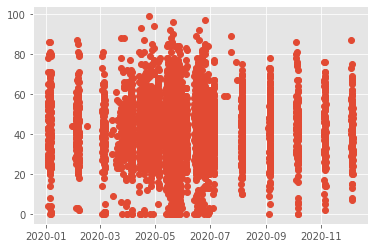

In [12]:
# Distribuição das idades por data de confirmação 
d = dates.date2num(df_dataset.dt_notificacao)
plot_date(d, df_dataset.idade)

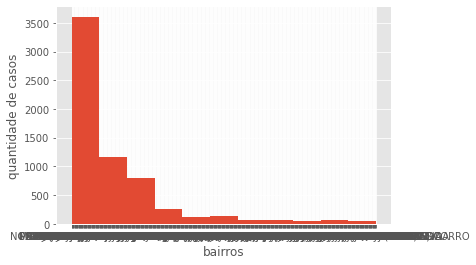

In [13]:
x = df_dataset.bairro.values
plt.hist(x, density=False, bins=11)  # `density=False` would make counts
plt.ylabel('quantidade de casos')
plt.xlabel('bairros');

## Propondo terefa de ***classificação*** para a base de dados

### Tarefa: classificar se o "paciente" se recuperou ou não do covid-19

Com base nos dados solicitados pelo projeto, uma tarefa de classificação que pode ser realizada em cima dos dados é: classificar um "paciente" como *Recuperado* da covid-19 ou evoluiu para *Óbito*. Um dos problemas encontrados para realizar esta tarefa é o desbalenceamento de clases, pois enquanto a quantidade de "pacientes" recuperados é 6347 o número de pessoas com conclusão igual a Óbito chega a 13.

Uma possível forma de se contornar esse problema  do desbalenceamento das clases seria, selecionar outros atributos, pois observa-se que há bastante pessoas classificadas como Óbito, mas por causa da limpeza e escolha desses atributos do dataset atual essa classe diminuiu considerávelmente.

Outra sugestão para aumentar a quantidade de classes minoritária seria considerar mais registros com campos faltantes e depois adicionar a média do atributo para este campo ou outra encontrar outra medida para preencher tais campos.

### Avaliação da tarefa de classificação

Como se trata de uma classificação binária a acurácia é uma das principais métricas a ser considerada, porém para este conjunto de dados talvez não reflita a total realidade por ele apresentar quantidades de classes desbalanceadas, então a melhor maneira é adicionar outras métricas de válidação como por exemplo a precisão que diz quantos acertos para uma classe (true positives) sobre o total de classificados como positivos (true positives + false positives).

Aliados a estas métricas citadas a cima, acredita-se que as seguintes também tornariam a avaliação mais eficiente para o conjuto de dados considerado: *recall*, *f1-score* e também a *G-score* (bastante usada em casses desbalanceadas).

### Validação do modelo 

Para a validação do modelo, ou modelos caso se use mais de um para esta tarefa, pensou-se em criar dois experimentos um usando a partição holdout e um outro usando o válidação cruzada. O primeiro para aferir se com os daos é possível criar um bom classificador mesmo que tenha classes desbalanceadas e o segundo para garantir que o/os modelo/os possa ser treinado/os e testado/os com todos os registros e assim contornar o problema das classes desbalanceadas.

## Propondo uma tarefa de ***regressão*** para os dados

### Tarefa: prever a idade dos "pacientes" com base nos demais atributos

Uma das tarefas de regressão pensada para este problema foi a previsão da idade dos pacientes, pois como se base a taxa de letalidade é maior nas pessoas idosas, mas será que com a base de dados disponível usando atributos como bairro, e sexo situação de conclusão do paciente e data de notificação e tipo de test se consegue acertar a idade dele? Nesta tarefa, acreditasse que os atributos tipo_teste e df_notificação não tenham tanha relevância, pois eles não são características dos pacientes, mas sim dos testes que eles fizeram. 

## Bônus: Qual tarefa de Aprendizado Não-Supervisionado poderia ser concebida neste contexto?

Considerando o dataset limpo e preprocessado e com quantidade de atributos disponíveis. Uma tarefa de apredizado não supervisionado que poderia ser feita é o agrupamento de perfis de pacientes mais parecidos, ou seja, agrupar os pacientes com base nas suas caracteríscas. Uma meneira de realizar essa tarefa seria o usando o algoritmo *KNN* para realizar esse agrupamento e descobrir os perfis de quem se recuperou ou morreu por exemplo.